# Classifying Hand-Written Digits

RJ Nowling
12/13/2018

The [MNIST Digits](http://yann.lecun.com/exdb/mnist/) data set consists of 70,000 28x28 pixel images of handwritten digits.  This data set is a popular and commonly used data set for image classification because it's simple enough for basic machine learning methods to work decently while complex enough to illustrate the benefits of more advanced methods like convolutional neural networks.

In this lab, we are going to create and evaluate a Logistic Regression model.  You will learn the basics of working with images through this example.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import umap

%matplotlib inline

## Data Loading and Exploration

First, we download the MNIST digits data set.

In [2]:
mnist = fetch_mldata('MNIST original')

Let's find out what the fields are of the object stored in the mnist data set:

In [3]:
dir(mnist)

['COL_NAMES', 'DESCR', 'data', 'target']

In [4]:
mnist.DESCR

'mldata.org dataset: mnist-original'

We are primarily interested in the `data` and `target` fields.  These are numpy arrays, so let's print their dimensions.

In [5]:
mnist.data.shape, mnist.target.shape

((70000, 784), (70000,))

We have a total of 70,000 28x28 images.  The images have been "reshaped" so that each image is stored as a 1D array of length 784.

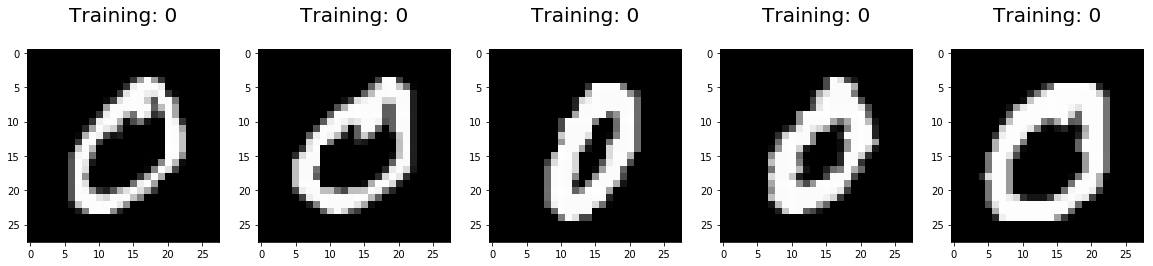

In [6]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(mnist.data[0:5], mnist.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

Since the image data is high dimensional and not composed of easy-to-understand columns, we need to approach our data exploration differently.  One approach is to use dimensionality reduction or clustering techniques to visualize the relationships between groups of samples.  Dimensionality reduction reduces the number of variables (columns), while clustering reduces the number of samples.  These are both forms of unsupervised learning.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction.  We'll start with that.

In [10]:
pca = PCA(n_components = 10, whiten=True)
projected = pca.fit_transform(mnist.data)

After we train the PCA model, we need to determine the number of components that capture meaningful information.  We can do this by plotting the explained variance ratios for each component and look for the point BEFORE the curve plateaus.

Text(0,0.5,'Explained Variance Ratio')

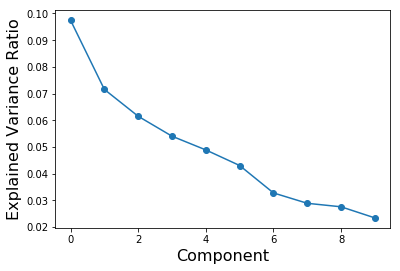

In [12]:
plt.plot(pca.explained_variance_ratio_, marker="o")
plt.xlabel("Component", fontsize=16)
plt.ylabel("Explained Variance Ratio", fontsize=16)

Next, we can plot the coordinates of the images along each component in a scatter plot.  We are looking for a clustering pattern where images for the different digits are bunched together but separate from the images for different digits.

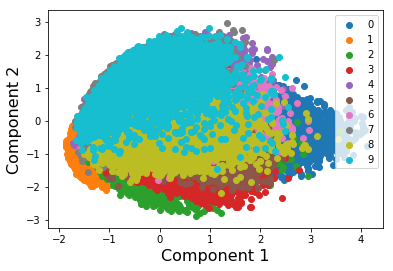

In [14]:
for i in range(10):
    plt.scatter(projected[mnist.target == i, 0],
                projected[mnist.target == i, 1],
                label=str(i))
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend()

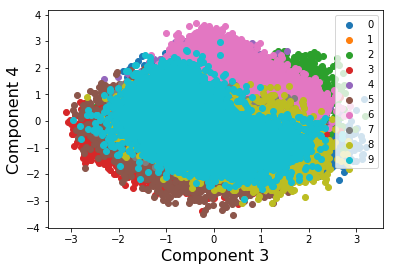

In [16]:
for i in range(10):
    plt.scatter(projected[mnist.target == i, 2],
                projected[mnist.target == i, 3],
                label=str(i))
plt.xlabel("Component 3", fontsize=16)
plt.ylabel("Component 4", fontsize=16)
plt.legend()

PCA was not able to separate the samples.  This suggests that classifying these images will be somewhat challenging.

We will also Uniform Manifold Approximation and Projection (UMAP).  UMAP is a dimensionality reduction technique that is non-linear and based on distances between samples.  By default, UMAP will project the data to two dimensions but is capable of projecting to more dimensions.

In [34]:
umap_ = umap.UMAP()
proj = umap_.fit_transform(mnist.data)

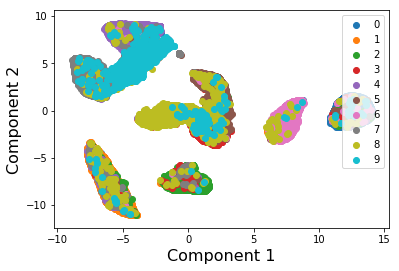

In [35]:
for i in range(10):
    plt.scatter(proj[mnist.target == i, 0],
                proj[mnist.target == i, 1],
                label=str(i))
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend()

UMAP does separate out some of the data points into clusters, but the clusters are not homogenous.  (There is a mixture of digits in each cluster.)

UMAP is somewhat unique in that it can also do supervised dimensionality reduction.  UMAP will try to find an embedding in a lower dimensional space that preserves the relationships between the classes.

In [32]:
umap_ = umap.UMAP()
proj = umap_.fit_transform(mnist.data, y=mnist.target)

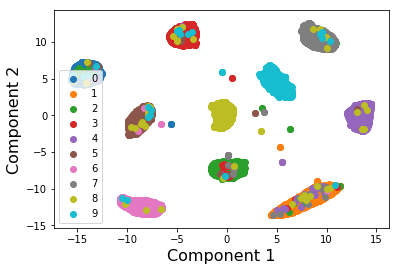

In [33]:
for i in range(10):
    plt.scatter(proj[mnist.target == i, 0],
                proj[mnist.target == i, 1],
                label=str(i))
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend()

The supervised dimensionality reduction creates clusters that are purer than the unsupervised dimensionality reduction.

## Experimental Setup

Just like when working with structured data, we need to divide our images into training and testing sets.

In [7]:
train_X, test_X, train_y, test_y = train_test_split(mnist.data,
                                                    mnist.target,
                                                    test_size=10000,
                                                    stratify=mnist.target)

## Build and Evaluate Model

We'll start by building a Logistic Regression model using just the images' pixels.

In [30]:
lr = SGDClassifier(loss="log", max_iter=250)
lr.fit(train_X, train_y)
pred_y = lr.predict(test_X)

print("Accuracy:", accuracy_score(test_y, pred_y))
print("Confusion Matrix:", confusion_matrix(test_y, pred_y))

Accuracy: 0.8824
Confusion Matrix: [[ 951    0    7    7    1    7    6    3    1    3]
 [   0 1061   18   17    1   10    1    2    8    7]
 [   6    6  902   33    7    1    4   15   18    7]
 [   2    0   33  940    2    6    2    7   13   15]
 [   6    3   11    8  878    3    8   14    7   37]
 [   8    0   11  105   17  699   10    8   31   13]
 [   8    4   25    7    6   18  900    1   13    0]
 [   5    1   12   12    8    2    1  963    1   37]
 [  10   18   57   85   17   32    3    8  694   51]
 [   4    1    7   37   31    5    0   71    2  836]]


We will now try augmenting the pixel values with features created by PCA and UMAP.

In [31]:
pca = PCA(n_components=10, whiten=True)
proj_train = pca.fit_transform(train_X)
proj_test = pca.transform(test_X)

train_aug_X = np.hstack([train_X, proj_train])
test_aug_X = np.hstack([test_X, proj_test])

lr = SGDClassifier(loss="log", max_iter=250)
lr.fit(train_aug_X, train_y)
pred_y = lr.predict(test_aug_X)

print("Accuracy:", accuracy_score(test_y, pred_y))
print("Confusion Matrix:", confusion_matrix(test_y, pred_y))


Accuracy: 0.8734
Confusion Matrix: [[ 952    0   10    2    1    5    2    1   13    0]
 [   0 1069   26    8    2    1    0    3   12    4]
 [   7    7  925    9    5    1    0   13   28    4]
 [   3    0   60  878    8    0    1    8   40   22]
 [   8    2   19    1  862    0    4    8   14   57]
 [  12    1   22   59   38  557   24    3  170   16]
 [  19    4   46    6   12    3  861    0   31    0]
 [   5    2   21    6   11    0    0  963    2   32]
 [   8   18   36   36   11    8    4    5  810   39]
 [   4    1    9   18   28    1    0   57   19  857]]


In [37]:
umap_ = umap.UMAP(n_components=5)
proj_train = umap_.fit_transform(train_X, y=mnist.target)
proj_test = umap_.transform(test_X)

train_aug_X = np.hstack([train_X, proj_train])
test_aug_X = np.hstack([test_X, proj_test])

lr = SGDClassifier(loss="log", max_iter=250)
lr.fit(train_aug_X, train_y)
pred_y = lr.predict(test_aug_X)

print("Accuracy:", accuracy_score(test_y, pred_y))
print("Confusion Matrix:", confusion_matrix(test_y, pred_y))


Accuracy: 0.9054
Confusion Matrix: [[ 980    0    2    1    0    1    1    0    1    0]
 [   0 1102    9    0    1    2    2    2    2    5]
 [  20   11  936    1    4    0    4    8   11    4]
 [  21    9   42  858    0   40    8    5   30    7]
 [  11    4    3    0  878    2   20    2    7   48]
 [  27    1   11   31    5  731   37    3   49    7]
 [  14    2    6    1    1    7  949    0    2    0]
 [  12    4   15    4   13    1    1  906    6   80]
 [  18   19   17   14    7   21   11    1  845   22]
 [  18   11    4   12   37    4    0   26   13  869]]


With the pixel-only features, our Logistic Regression model achieves an accuracy of 88%.  The PCA-augmented features produce a worse model, achieving an accuracy of 87%.  The UMAP-augmented features improves our results slightly with an accuracy of 91%.